## Collaborative Filtering Recommenders 
Aim: to recomend company with new custmers of potential high spendings in the company 
> By modify dol-related worthiness score designed (i.e. rating by company for customers)


### Python Surprise library, with suitable Visual Studios depending on Python versions
http://surprise.readthedocs.io/en/v1.0.2/
    > $ pip install numpy scikit-surprise



### Summary of I/O csv files

Input Files
    > "train_dol.txt"     - all company-customer level spendings in training period
    > "test_dol.txt"      - potential customers with actual spendings in testing period for company 36
    > "scale_train_dol.txt"    - min-max scaled
    > "scale_test_dol.txt"     - min-max scaled
    > "train_dol_log.txt"      - log transformed
    > "test_dol_log.txt"       - log transformed
    > "scale_train_dol_log.txt"- log transformed and min-max scaled
    > "scale_test_dol_log.txt" - log transformed and min-max scaled

Output Files

    > Results and summary based on dollars, "summary_" 
    with_mean_cf_basics_knn_dol.csv
    with_mean_cf_basics_svd_dol.csv
    with_mean_cf_basics_cocluster_dol.csv
    > Results and summary based on dollars with min-max scaling, "summary_" 
    actual_with_mean_cf_basics_knn_dolscale_.csv
    actual_with_mean_cf_basics_svd_dolscale_.csv
    actual_with_mean_cf_basics_cocluster_dolscale_.csv    
    > Results and summary based on log-transformed dollars, "summary_"
    actual_with_mean_cf_basics_knn_dol_log.csv
    actual_with_mean_cf_basics_svd_dol_log.csv
    actual_with_mean_cf_basics_cocluster_dol_log.csv    
    > Results and summary based on log-transformed dollars with min-max scaling, "summary_"
    actual_with_mean_cf_basics_knn_dol_logscale_.csv
    actual_with_mean_cf_basics_svd_dol_logscale_.csv
    actual_with_mean_cf_basics_knn_dol_logscale_.csv

# Start with Dollars for both Train and Test

In [1]:
""" not scaled, dol"""
from surprise import Dataset                                                      
from surprise import Reader                                                      

reader = Reader(line_format='user item rating', sep='\t')
measures = ["dol", "dol_log", "num", "num_log"]
measure = measures[0] #"dol"

train_file = "train_"+ measure +".txt"
test_file = "test_"+ measure +".txt"

# each line has the following format: 'user item rating', separated by '\t' characters. #cols = ["CompanyID","HH_ID","Dollars"]
reader = Reader(line_format='user item rating', sep='\t')
data = Dataset.load_from_folds([(train_file, test_file)], reader=reader)

In [2]:
from surprise.accuracy import rmse
import numpy as np
import pandas as pd
import time

def predict(algo):
    for trainset, testset in data.folds():                                                       
        algo.train(trainset)                             
        predictions = algo.test(testset)
        rmse(predictions)
        return(predictions)

def summarize(predictions,algo_name, measure):
    scale = "" # else "_scale"
    output_name = "cf_basics_" + algo_name + "_" + measure + scale + ".csv"
    results_df = pd.DataFrame.from_dict(predictions)
    results_df = results_df.sort_values(by="est",ascending=False).reset_index(drop=True)
    results_df.columns = ["CompanyID", "HH_ID", "ActualRevenue","Dollars","Details"]
    # Output to csv
    results_df.to_csv(output_name, index=False)
    print(output_name)
    sample = results_df.ix[results_df.HH_ID=='343']
    print(sample)
    """ Summary Statitics, Mean_est_dol refers to worthiness"""
    quant = [0,10,20,30,40,50,60,70,80,90,100]
    quant_est = np.percentile(results_df.index,quant)
    groups =  results_df.groupby(pd.cut(results_df.index, quant_est, include_lowest=True))
    df4 = groups.agg({"HH_ID": 'count', 'Dollars': 'mean', "ActualRevenue":'mean'})
    df4["percentile"] = quant[1:]
    df4 = df4[["percentile", "HH_ID","Dollars","ActualRevenue"]]
    # Output to csv
    df4.to_csv("summary_"+output_name, index=False)
    
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
""" knn basic"""
from surprise import KNNBasic
start = time.time()
algo = KNNBasic()
algo_name = "knn"
predictions_knn = predict(algo)
summarize(predictions_knn,algo_name,measure)
timer(start,time.time()) 

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 9.9981
cf_basics_knn_dol.csv
        CompanyID HH_ID  ActualRevenue  Dollars  \
1303143        36   343           28.0      5.0   

                                          Details  
1303143  {'actual_k': 5, 'was_impossible': False}  
00:31:58.28


In [5]:
""" SVD """
from surprise import SVD
start = time.time()
algo = SVD()
algo_name = "svd"
predictions_svd = predict(algo)
summarize(predictions_svd,algo_name,measure)
timer(start,time.time()) 

RMSE: 9.9993
cf_basics_svd_dol.csv
        CompanyID HH_ID  ActualRevenue  Dollars                    Details
1303976        36   343           28.0        5  {'was_impossible': False}
00:27:26.20


In [4]:
"""co clustering"""
from surprise import CoClustering 
start = time.time()
algo = CoClustering()                                                       
algo_name = "cocluster"
predictions_cc = predict(algo)
summarize(predictions_cc,algo_name,measure)
timer(start,time.time())

RMSE: 9.5782
cf_basics_cocluster_dol.csv
        CompanyID HH_ID  ActualRevenue  Dollars                    Details
1390042        36   343           28.0      1.0  {'was_impossible': False}
00:21:17.52


### Issue identified: 
> in some n*10th percentile, the predicted worthiness score are same but the actual revenue are very different 

> This is because the predicted worthness score may be the same for *toooo* many HH_ID, so they fall in different percentile bins.

Resove this issue by：
> Obtain the mean actual revenue for each group of predictions with the same worthiness score

In [28]:
""" Further Analysis：add mean to actual revenue for each group """
file_names = ["cf_basics_knn_dol.csv","cf_basics_svd_dol.csv","cf_basics_cocluster_dol.csv"]
for file in file_names: 
    output_name = "with_mean_" + file
    print(output_name)
    results_df = pd.read_csv(file)
    results_df = results_df.join(results_df.groupby('Dollars')['ActualRevenue'].mean(), on='Dollars', rsuffix='Mean')
    # Output to csv
    results_df.to_csv(output_name, index=False)    
    # Summary statistics
    quant = [0,10,20,30,40,50,60,70,80,90,100]
    quant_est = np.percentile(results_df.index,quant)
    groups =  results_df.groupby(pd.cut(results_df.index, quant_est, include_lowest=True))
    df4 = groups.agg({"HH_ID": 'count', 'Dollars': 'mean', "ActualRevenueMean":'mean'})
    df4["percentile"] = quant[1:]
    df4 = df4[["percentile", "HH_ID","Dollars","ActualRevenueMean"]]
    # Output to csv
    df4.to_csv("summary_"+output_name, index=False)

#### Plot accumulative average dollars vs number of potential customer recommeded


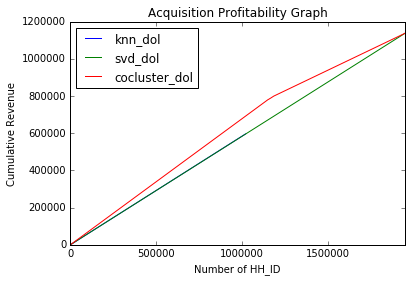

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
list_ = []
algo_names = ["knn","svd","cocluster"]
for algo_name in algo_names:
    file_name = "with_mean_cf_basics_"+ algo_name + "_dol.csv"
    predictions = pd.read_csv(file_name)
    # (Actual Revenue Mean) CumSum
    algo_name = algo_name+"_dol"
    predictions[algo_name] = predictions.ActualRevenueMean.cumsum()
    list_.append(predictions[algo_name])
plt.figure()
graph = pd.concat(list_, axis=1) ## (Actual Revenue Mean) CumSum
graph.plot(title='Acquisition Profitability Graph')
plt.xlabel('Number of HH_ID')
plt.ylabel('Cumulative Revenue')
plt.savefig("dol_as_score_acquisition_profitability_curve.jpeg")

# Step 2:  Scale Dollars for both Train and Test

In [39]:
""" scaled, dol"""
scale = "scale_"

train_file = scale + "train_"+ measure +".txt"
test_file = scale + "test_"+ measure +".txt"

# each line has the following format: 'user item rating', separated by '\t' characters. #cols = ["CompanyID","HH_ID","Dollars"]
reader = Reader(line_format='user item rating', sep='\t')
data = Dataset.load_from_folds([(train_file, test_file)], reader=reader)

In [42]:
def summarize(predictions,algo_name, measure):
    output_name = "with_mean_" + "cf_basics_" + algo_name + "_" + measure + scale + ".csv"
    results_df = pd.DataFrame.from_dict(predictions)
    results_df = results_df.sort_values(by="est",ascending=False).reset_index(drop=True)
    results_df.columns = ["CompanyID", "HH_ID", "ActualRevenue","Dollars","Details"]
    results_df = results_df.join(results_df.groupby('Dollars')['ActualRevenue'].mean(), on='Dollars', rsuffix='Mean')    
    # Output to csv
    results_df.to_csv(output_name, index=False)
    print(output_name)
    sample = results_df.ix[results_df.HH_ID=='343']
    print(sample)

In [43]:
"""co clustering"""
from surprise import CoClustering #http://surprise.readthedocs.io/en/latest/co_clustering.html
start = time.time()
algo = CoClustering()                                                       
algo_name = "cocluster"
predictions_cc = predict(algo)
summarize(predictions_cc,algo_name,measure)
timer(start,time.time())

RMSE: 0.0156
with_mean_cf_basics_cocluster_dolscale_.csv
        CompanyID HH_ID  ActualRevenue  Dollars                    Details  \
1303977        36   343       1.048214      1.0  {'was_impossible': False}   

         ActualRevenueMean  
1303977           1.001004  
00:33:15.80


In [45]:
""" knn basic"""
from surprise import KNNBasic
start = time.time()
algo = KNNBasic()
algo_name = "knn"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time()) # Python Notebook Shutted down for unknown reason, with csv files saved and results diaplayed

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0166
with_mean_cf_basics_knn_dolscale_.csv
        CompanyID HH_ID  ActualRevenue   Dollars  \
1446135        36   343       1.048214  1.000822   

                                          Details  ActualRevenueMean  
1446135  {'actual_k': 5, 'was_impossible': False}           1.003444  
00:06:49.02


In [46]:
""" SVD """
from surprise import SVD
start = time.time()
algo = SVD()
algo_name = "svd"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time()) 

RMSE: 0.0155
with_mean_cf_basics_svd_dolscale_.csv
        CompanyID HH_ID  ActualRevenue  Dollars                    Details  \
1895458        36   343       1.048214      1.0  {'was_impossible': False}   

         ActualRevenueMean  
1895458           1.000594  
00:39:31.25


In [68]:
""" Further Analysis：add mean to actual revenue for each group """
""" Reference to another file to get actual revenue, genreal popularity is used here"""
df = pd.read_csv("popularity_company_36.csv")

algo_names = ["knn","svd","cocluster"]
for algo_name in algo_names:
    file_name = "with_mean_cf_basics_"+algo_name+"_dolscale_.csv"
    results_df = pd.read_csv(file_name)    
    results_df = results_df[['HH_ID', 'Dollars']]
    results_df.columns = ['HH_ID', 'Score']
    result = pd.merge(results_df, df[['HH_ID', 'ActualRevenue']], on='HH_ID')
    results_df = result.join(result.groupby('Score')['ActualRevenue'].mean(), on='Score', rsuffix='Mean')    
    #Output to csv
    output_name = "actual_" + file_name
    results_df.to_csv(output_name, index=False)
    print(output_name)
    # Summary to csv
    quant = [0,10,20,30,40,50,60,70,80,90,100]
    quant_est = np.percentile(results_df.index,quant)
    groups =  results_df.groupby(pd.cut(results_df.index, quant_est, include_lowest=True))
    df4 = groups.agg({"HH_ID": 'count', 'Score': 'mean', "ActualRevenue":'mean', "ActualRevenueMean":'mean'})
    df4["percentile"] = quant[1:]
    df4 = df4[["percentile", "HH_ID","Score","ActualRevenue","ActualRevenueMean"]]
    
    df4.to_csv("summary_"+output_name, index=False)

actual_with_mean_cf_basics_knn_dolscale_.csv
actual_with_mean_cf_basics_svd_dolscale_.csv
actual_with_mean_cf_basics_cocluster_dolscale_.csv


#### Plot accumulative average dollars vs number of potential customer recommeded


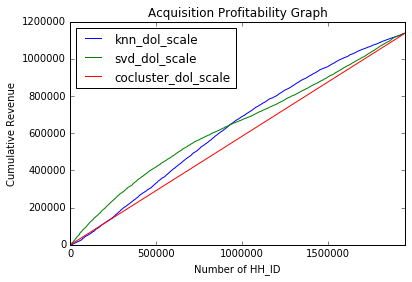

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
list_ = []
algo_names = ["knn","svd","cocluster"]
for algo_name in algo_names:
    file_name = "actual_with_mean_cf_basics_"+ algo_name + "_dolscale_.csv"
    predictions = pd.read_csv(file_name)
    # (Actual Revenue Mean) CumSum
    algo_name = algo_name+"_dol_scale"
    predictions[algo_name] = predictions.ActualRevenueMean.cumsum()
    list_.append(predictions[algo_name])
plt.figure()
graph = pd.concat(list_, axis=1) ## (Actual Revenue Mean) CumSum
graph.plot(title='Acquisition Profitability Graph')
plt.xlabel('Number of HH_ID')
plt.ylabel('Cumulative Revenue')
plt.savefig("dol_scale_as_score_acquisition_profitability_curve.jpeg")

# Step 3:  Log-trasformation Dollars for both Train and Test

In [71]:
""" not scaled, log dol"""
scale = ""
measures = ["dol", "dol_log", "num", "num_log"]
measure = measures[1] #"dol_log"

train_file = scale + "train_"+ measure +".txt"
test_file = scale + "test_"+ measure +".txt"

# each line has the following format: 'user item rating', separated by '\t' characters. #cols = ["CompanyID","HH_ID","Dollars"]
reader = Reader(line_format='user item rating', sep='\t')
data = Dataset.load_from_folds([(train_file, test_file)], reader=reader)

In [73]:
def summarize(predictions,algo_name, measure):
    output_name = "cf_basics_" + algo_name + "_" + measure + scale + ".csv"
    results_df = pd.DataFrame.from_dict(predictions)
    results_df = results_df.sort_values(by="est",ascending=False).reset_index(drop=True)
    results_df.columns = ["CompanyID", "HH_ID", "ActualLogRevenue","Score","Details"]
    # Output to csv
    results_df.to_csv(output_name, index=False)
    print(output_name)
    sample = results_df.ix[results_df.HH_ID=='343']
    print(sample)

In [74]:
"""co clustering"""
from surprise import CoClustering #http://surprise.readthedocs.io/en/latest/co_clustering.html
start = time.time()
algo = CoClustering()                                                       
algo_name = "cocluster"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time())

RMSE: 3.5792
cf_basics_cocluster_dol_log.csv
        CompanyID HH_ID  ActualLogRevenue     Score                    Details
1635084        36   343          3.367296  2.279622  {'was_impossible': False}
00:34:53.14


In [76]:
""" knn basic"""
from surprise import KNNBasic
start = time.time()
algo = KNNBasic()
algo_name = "knn"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time()) # Python Notebook Shutted down for unknown reason, with csv files saved and results diaplayed

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 4.3425
cf_basics_knn_dol_log.csv
        CompanyID HH_ID  ActualLogRevenue     Score  \
1664903        36   343          3.367296  3.451028   

                                          Details  
1664903  {'actual_k': 5, 'was_impossible': False}  
00:07:19.17


In [77]:
""" SVD """
from surprise import SVD
start = time.time()
algo = SVD()
algo_name = "svd"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time()) 

RMSE: 3.7073
cf_basics_svd_dol_log.csv
        CompanyID HH_ID  ActualLogRevenue     Score                    Details
1724864        36   343          3.367296  3.546063  {'was_impossible': False}
00:43:18.58


In [78]:
""" Further Analysis：add mean to actual revenue for each group """
algo_names = ["knn","svd","cocluster"]
for algo_name in algo_names:
    file_name = "cf_basics_"+algo_name+"_dol_log.csv"
    results_df = pd.read_csv(file_name)    #["CompanyID", "HH_ID", "ActualLogRevenue","Score","Details"]
    results_df = results_df[['HH_ID', 'Score']]
    result = pd.merge(results_df, df[['HH_ID', 'ActualRevenue']], on='HH_ID')
    results_df = result.join(result.groupby('Score')['ActualRevenue'].mean(), on='Score', rsuffix='Mean')    
    #Output to csv
    output_name = "actual_with_mean_" + file_name
    results_df.to_csv(output_name, index=False)
    print(output_name)
    # Summary to csv
    quant = [0,10,20,30,40,50,60,70,80,90,100]
    quant_est = np.percentile(results_df.index,quant)
    groups =  results_df.groupby(pd.cut(results_df.index, quant_est, include_lowest=True))
    df4 = groups.agg({"HH_ID": 'count', 'Score': 'mean', "ActualRevenue":'mean', "ActualRevenueMean":'mean'})
    df4["percentile"] = quant[1:]
    df4 = df4[["percentile", "HH_ID","Score","ActualRevenue","ActualRevenueMean"]]    
    df4.to_csv("summary_"+output_name, index=False)

actual_with_mean_cf_basics_knn_dol_log.csv
actual_with_mean_cf_basics_svd_dol_log.csv
actual_with_mean_cf_basics_cocluster_dol_log.csv


#### Plot accumulative average dollars vs number of potential customer recommeded


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
list_ = []
algo_names = ["knn","svd","cocluster"]
for algo_name in algo_names:
    file_name = "actual_with_mean_cf_basics_"+ algo_name + "_dol_log.csv"
    predictions = pd.read_csv(file_name)
    # (Actual Revenue Mean) CumSum
    algo_name = algo_name+"_dol_log"
    predictions[algo_name] = predictions.ActualRevenueMean.cumsum()
    list_.append(predictions[algo_name])
plt.figure()
graph = pd.concat(list_, axis=1) ## (Actual Revenue Mean) CumSum
graph.plot(title='Acquisition Profitability Graph')
plt.xlabel('Number of HH_ID')
plt.ylabel('Cumulative Revenue')
plt.savefig("dol_log_as_score_acquisition_profitability_curve.jpeg")

# Step 4:  Min-Max Scalling of LogDollars for both Train and Test

In [80]:
""" Sscaled, log dol"""
scale = "scale_"
measures = ["dol", "dol_log", "num", "num_log"]
measure = measures[1] #"dol_log"

train_file = scale + "train_"+ measure +".txt"
test_file = scale + "test_"+ measure +".txt"

# each line has the following format: 'user item rating', separated by '\t' characters. #cols = ["CompanyID","HH_ID","Dollars"]
reader = Reader(line_format='user item rating', sep='\t')
data = Dataset.load_from_folds([(train_file, test_file)], reader=reader)

In [81]:
""" knn basic"""
from surprise import KNNBasic
start = time.time()
algo = KNNBasic()
algo_name = "knn"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time()) # Python Notebook Shutted down for unknown reason, with csv files saved and results diaplayed

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4845
cf_basics_knn_dol_logscale_.csv
        CompanyID HH_ID  ActualLogRevenue    Score  \
1665622        36   343          2.737725  2.11481   

                                          Details  
1665622  {'actual_k': 5, 'was_impossible': False}  
00:04:32.74


In [82]:
"""co clustering"""
from surprise import CoClustering #http://surprise.readthedocs.io/en/latest/co_clustering.html
start = time.time()
algo = CoClustering()                                                       
algo_name = "cocluster"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time())

RMSE: 0.9245
cf_basics_cocluster_dol_logscale_.csv
        CompanyID HH_ID  ActualLogRevenue     Score                    Details
1806422        36   343          2.737725  1.302278  {'was_impossible': False}
00:21:56.91


In [83]:
""" SVD """
from surprise import SVD
start = time.time()
algo = SVD()
algo_name = "svd"
predictions = predict(algo)
summarize(predictions,algo_name,measure)
timer(start,time.time()) 

RMSE: 1.2045
cf_basics_svd_dol_logscale_.csv
        CompanyID HH_ID  ActualLogRevenue     Score                    Details
1872385        36   343          2.737725  2.134053  {'was_impossible': False}
00:30:49.54


In [84]:
""" Further Analysis：add mean to actual revenue for each group """
algo_names = ["knn","svd","cocluster"]
for algo_name in algo_names:
    file_name = "cf_basics_"+algo_name+"_dol_logscale_.csv"
    results_df = pd.read_csv(file_name)    #["CompanyID", "HH_ID", "ActualLogRevenue","Score","Details"]
    results_df = results_df[['HH_ID', 'Score']]
    result = pd.merge(results_df, df[['HH_ID', 'ActualRevenue']], on='HH_ID')
    results_df = result.join(result.groupby('Score')['ActualRevenue'].mean(), on='Score', rsuffix='Mean')    
    #Output to csv
    output_name = "actual_with_mean_" + file_name
    results_df.to_csv(output_name, index=False)
    print(output_name)
    # Summary to csv
    quant = [0,10,20,30,40,50,60,70,80,90,100]
    quant_est = np.percentile(results_df.index,quant)
    groups =  results_df.groupby(pd.cut(results_df.index, quant_est, include_lowest=True))
    df4 = groups.agg({"HH_ID": 'count', 'Score': 'mean', "ActualRevenue":'mean', "ActualRevenueMean":'mean'})
    df4["percentile"] = quant[1:]
    df4 = df4[["percentile", "HH_ID","Score","ActualRevenue","ActualRevenueMean"]]    
    df4.to_csv("summary_"+output_name, index=False)

actual_with_mean_cf_basics_knn_dol_logscale_.csv
actual_with_mean_cf_basics_svd_dol_logscale_.csv
actual_with_mean_cf_basics_cocluster_dol_logscale_.csv


#### Plot accumulative average dollars vs number of potential customer recommeded


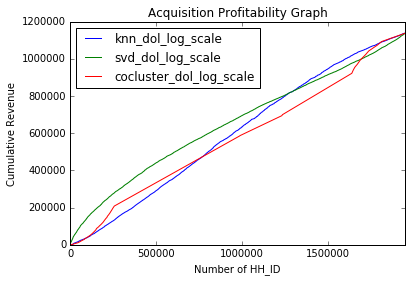

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
list_ = []
algo_names = ["knn","svd","cocluster"]
for algo_name in algo_names:
    file_name = "actual_with_mean_cf_basics_"+ algo_name + "_dol_logscale_.csv"
    predictions = pd.read_csv(file_name)
    # (Actual Revenue Mean) CumSum
    algo_name = algo_name+"_dol_log_scale"
    predictions[algo_name] = predictions.ActualRevenueMean.cumsum()
    list_.append(predictions[algo_name])
plt.figure()
graph = pd.concat(list_, axis=1) ## (Actual Revenue Mean) CumSum
graph.plot(title='Acquisition Profitability Graph')
plt.xlabel('Number of HH_ID')
plt.ylabel('Cumulative Revenue')
plt.savefig("dol_log_scale_as_score_acquisition_profitability_curve.jpeg")